![](https://fenc.wang/imgs/2020/08/3565654bfbe9ffa0.png)

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker 
import matplotlib.animation as animation
from IPython.display import HTML
mpl.rcParams['animation.embed_limit'] = 2**128

import tushare as ts
import pandas as pd
from functools import reduce
import datetime
from pandas.tseries.offsets import *

import pymysql
pymysql.install_as_MySQLdb()
from sqlalchemy import create_engine 

#设置完整显示数据
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format', '{:,.2f}'.format)

# tushare的token api
pro = ts.pro_api('xxxxxxxxxxxxxxxxxxxxxxxxx')

#填写mysql的相关信息，地址、table、密码
engine_ts = create_engine('mysql://数据库:密码@地址:3306/table')


In [2]:
#选取mysql中的数据库kcb_data
def read_sql(dtype):
    sql = "SELECT `ts_code`, `name`,`trade_date`,`industry`,`%s`,'' FROM kcb_data" %(dtype)
    df = pd.read_sql_query(sql, engine_ts)
    return df
#turnover_rate,turnover_rate_f,volume_ratio,pe,pe_ttm,pb,ps,ps_ttm,dv_ratio,dv_ttm,total_share,float_share,free_share,total_mv,circ_mv,ts_type,name,industry,list_date,id
df = read_sql('total_mv')
df['total_mv'] = df['total_mv'].div(10000)  #用作total_mv，将数值转为以“亿”为单位，选取其他指标的，这里可以注释掉
df = df.fillna(0)
df = df.rename(columns={'total_mv':'indicator'})

In [3]:
dff = df[df['trade_date'].str.contains("20190722")]
dff.head()

,ts_code,name,trade_date,industry,indicator,
1454,688012.SH,中微公司,20190722,专用机械,433.40,
1941,688016.SH,心脉医疗,20190722,医疗保健,113.94,
2027,688122.SH,西部超导,20190722,小金属,242.66,
2316,688020.SH,方邦股份,20190722,元器件,80.88,
3931,688010.SH,福光股份,20190722,电器仪表,74.75,


<BarContainer object of 25 artists>

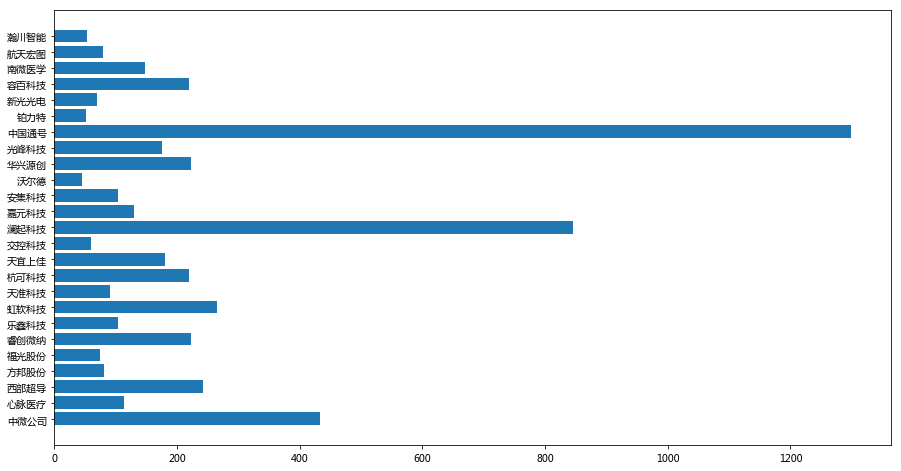

In [4]:
fig, ax = plt.subplots(figsize=(15, 8))
ax.barh(dff['name'], dff['indicator'])

In [5]:
len(df['industry'].unique())

28

In [6]:
colors = dict(zip(
    ['软件服务', '通信设备', '专用机械', '元器件', '矿物制品', '运输设备', '化学制药', '生物制药',
       '半导体', '电气设备', '医疗保健', '家用电器', '机械基件', '小金属', '环境保护', '机床制造',
       '汽车配件', '互联网', '塑料', '化工原料', '化纤', '特种钢', '染料涂料', 'IT设备', '电器仪表',
       '食品', '航空', '农业综合'],
    ['#adb0ff', '#ffb3ff', '#90d595', '#e48381',
     '#aafbff', '#f7bb5f', '#eafb50','#adb0ff', '#ffb3ff', '#90d595', '#e48381',
     '#aafbff', '#f7bb5f', '#eafb50','#adb0ff', '#ffb3ff', '#90d595', '#e48381',
     '#aafbff', '#f7bb5f', '#eafb50','#adb0ff', '#ffb3ff', '#90d595', '#e48381',
     '#aafbff', '#f7bb5f', '#eafb50']
))
group_lk = df.set_index('name')['industry'].to_dict()

Text(1, 0.4, '20190722')

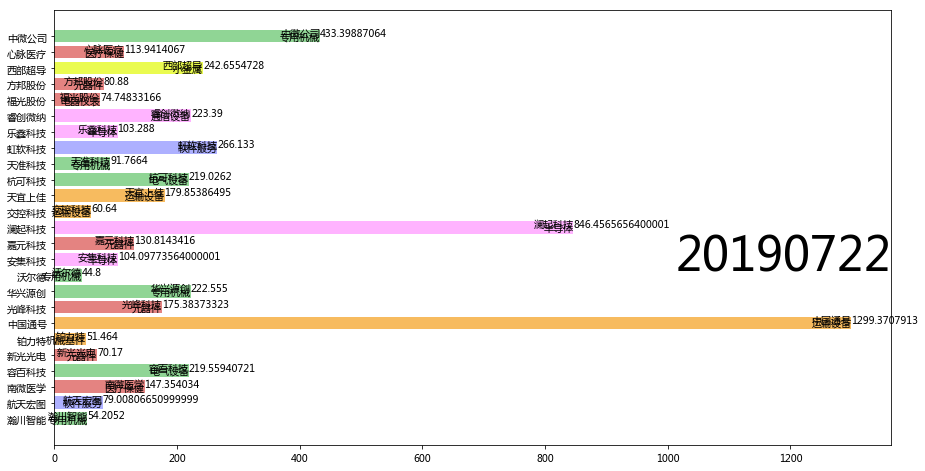

In [7]:
fig, ax = plt.subplots(figsize=(15, 8))
dff = dff[::-1]   # 从上到下翻转值
# 将颜色值传递给`color=`
ax.barh(dff['name'], dff['indicator'], color=[colors[group_lk[x]] for x in dff['name']])
# 遍历这些值来绘制标签和值(Tokyo, Asia, 38194.2)
for i, (value, name) in enumerate(zip(dff['indicator'], dff['name'])):
    ax.text(value, i,     name,            ha='right')  # Tokyo: 名字
    ax.text(value, i-.25, group_lk[name],  ha='right')  # Asia: 组名
    ax.text(value, i,     value,           ha='left')   # 38194.2: 值
# 在画布右方添加年份
current_year = 20190722
ax.text(1, 0.4, current_year, transform=ax.transAxes, size=46, ha='right')


In [ ]:
fig, ax = plt.subplots(figsize=(15, 8))
def draw_barchart(year):
    dff = df[df['trade_date'].str.contains(year)].sort_values(by='indicator', ascending=True).tail(20)
    ax.clear()
    ax.barh(dff['name'], dff['indicator'], color=[colors[group_lk[x]] for x in dff['name']])
    dx = dff['indicator'].max() / 200
    for i, (value, name) in enumerate(zip(dff['indicator'], dff['name'])):
        ax.text(value-dx, i,     name,           size=14, weight=600, ha='right', va='bottom')
        ax.text(value-dx, i-.25, group_lk[name], size=10, color='#444444', ha='right', va='baseline')
        ax.text(value+dx, i,     f'{value:,.0f}',  size=14, ha='left',  va='center')
    # ... polished styles
    ax.text(1, 0.4, year, transform=ax.transAxes, color='#777777', size=46, ha='right', weight=800)
    ax.text(0, 1.06, 'Population (thousands)', transform=ax.transAxes, size=12, color='#777777')
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
    ax.xaxis.set_ticks_position('top')
    ax.tick_params(axis='x', colors='#777777', labelsize=12)
    ax.set_yticks([])
    ax.margins(0, 0.01)
    ax.grid(which='major', axis='x', linestyle='-')
    ax.set_axisbelow(True)
    ax.text(0, 1.12, '20190722至今，科创板股票的市值徘行榜',
            transform=ax.transAxes, size=24, weight=600, ha='left')
#     ax.text(1, 0, 'by QIML', transform=ax.transAxes, ha='right',
#             color='#777777', bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))
    plt.box(False)
    
draw_barchart('20190722')


In [ ]:

import matplotlib.animation as animation
from IPython.display import HTML
fig, ax = plt.subplots(figsize=(15, 8))

date_generated = sorted(df['trade_date'].unique())
   
    
animator = animation.FuncAnimation(fig, draw_barchart, frames=date_generated)
HTML(animator.to_jshtml()) 
# or use animator.to_html5_video() or animator.save() or to_jshtml()


![](https://fenc.wang/imgs/2020/08/3565654bfbe9ffa0.png)